## 2022 TBA Predictions

Load the training data into a pandas data frame.  

In [1]:
from __future__ import print_function
import pickle
#import time
import sys
sys.path.append('..')
import swagger_client as v3client
from swagger_client.rest import ApiException

filename = 'matches_2022.pkl'
matches = []
with open(filename, 'rb') as f:
    matches = pickle.load(f)


Preview a match object

In [2]:
non_empty = [k for k in matches['matches'].keys() if len(matches['matches'][k])>0]
data = [m for k in matches['matches'] for m in matches['matches'][k]]
data = [m for m in data if m.winning_alliance!='']
print(len(data))
red = [x for m in data for x in m.alliances.red.team_keys]
blue = [x for m in data for x in m.alliances.blue.team_keys]
from collections import Counter
Counter(red+blue)

5742


Counter({'frc6510': 19,
         'frc4613': 19,
         'frc5876': 19,
         'frc7561': 15,
         'frc6508': 15,
         'frc5988': 15,
         'frc5584': 20,
         'frc4774': 20,
         'frc6432': 20,
         'frc5985': 19,
         'frc3132': 18,
         'frc8844': 18,
         'frc4729': 15,
         'frc7128': 16,
         'frc7433': 17,
         'frc8875': 15,
         'frc5331': 15,
         'frc6476': 15,
         'frc6575': 13,
         'frc7163': 13,
         'frc4739': 15,
         'frc4537': 15,
         'frc6434': 15,
         'frc7583': 17,
         'frc5564': 17,
         'frc6050': 13,
         'frc6035': 16,
         'frc114': 18,
         'frc2122': 18,
         'frc1726': 17,
         'frc2486': 13,
         'frc2478': 29,
         'frc4984': 27,
         'frc2403': 33,
         'frc60': 17,
         'frc2240': 17,
         'frc3200': 17,
         'frc4068': 18,
         'frc1410': 14,
         'frc2288': 11,
         'frc7426': 13,
         'frc2083':

In [3]:
data[0].score_breakdown['blue'].keys()

endgameFields = Counter()
taxiFields = Counter()
for d in data:
   endgameFields[d.score_breakdown['blue']['endgameRobot1']]+=1
   endgameFields[d.score_breakdown['blue']['endgameRobot2']]+=1
   endgameFields[d.score_breakdown['blue']['endgameRobot3']]+=1
   taxiFields[d.score_breakdown['blue']['taxiRobot1']]+=1
   taxiFields[d.score_breakdown['blue']['taxiRobot2']]+=1
   taxiFields[d.score_breakdown['blue']['taxiRobot3']]+=1
print(endgameFields)
print(taxiFields)

for k in d.score_breakdown['blue']:
   if type(d.score_breakdown['blue'][k]) is not int:
      print(k, type(d.score_breakdown['blue'][k]))


Counter({'None': 9212, 'Mid': 4426, 'Traversal': 1943, 'High': 1140, 'Low': 505})
Counter({'Yes': 13301, 'No': 3925})
cargoBonusRankingPoint <class 'bool'>
endgameRobot1 <class 'str'>
endgameRobot2 <class 'str'>
endgameRobot3 <class 'str'>
hangarBonusRankingPoint <class 'bool'>
quintetAchieved <class 'bool'>
taxiRobot1 <class 'str'>
taxiRobot2 <class 'str'>
taxiRobot3 <class 'str'>


In [4]:
Counter([x.comp_level for x in data])

Counter({'f': 159, 'qf': 651, 'qm': 4613, 'sf': 319})

As you can see there is a lot of information here.  Suppose we want to collect all of this together so that at the end of the regionals we have score statistics for every team.  Let's aggregate stats for each of these fields: 'totalMatches', 
'autoPoints', 'cargoPoints', 'completeRocketRankingPoints', 'completedRocketCount', 'habLevel1Count', 'habLevel2Count', 'habLevel3Count', 'foulCount', 'foulPoints', 'rocketPanelCount', 'rocketCargoCount', 'bayPanelCount', 'bayCargoCount', 'habLineCount', 'habDockingRankingPoints', 'habClimbPoints', 'hatchPanelPoints', 'rankingPoints', 'sandStormBonusPoints', 'techFoulCount', 'teleopPoints', 'totalPoints', 'winCount'

In [5]:
qualifiers = [x for x in data if x.comp_level=='qm'] 

In [6]:
# ['adjustPoints', 'autoCargoLowerBlue', 'autoCargoLowerFar', 'autoCargoLowerNear', 'autoCargoLowerRed', 
# 'autoCargoPoints', 'autoCargoTotal', 'autoCargoUpperBlue', 'autoCargoUpperFar', 'autoCargoUpperNear', 
# 'autoCargoUpperRed', 'autoPoints', 'autoTaxiPoints', 'cargoBonusRankingPoint', 'endgamePoints', 
# 'endgameRobot1', 'endgameRobot2', 'endgameRobot3', 
# 'foulCount', 'foulPoints', 'hangarBonusRankingPoint', 'matchCargoTotal', 'quintetAchieved', 'rp', 
# 'taxiRobot1', 'taxiRobot2', 'taxiRobot3', 'techFoulCount', 
# 'teleopCargoLowerBlue', 'teleopCargoLowerFar', 'teleopCargoLowerNear', 'teleopCargoLowerRed', 
# 'teleopCargoPoints', 'teleopCargoTotal', 'teleopCargoUpperBlue', 'teleopCargoUpperFar', 'teleopCargoUpperNear', 
# 'teleopCargoUpperRed', 'teleopPoints', 'totalPoints']

# endgame: None': 6246, 'Mid': 2854, 'Traversal': 1177, 'High': 780, 'Low': 325}

teamAggregates = {}

def addMatch(team, m):    
    if team not in teamAggregates:       
        # initialize an empty record for the team.
        teamAggregates[team]= {
            'totalMatches':0, 
            'winCount': 0
        }
        for k in m.score_breakdown['blue'].keys():
            val = m.score_breakdown['blue'][k]
            if type(val) is int or type(val) is bool:
                teamAggregates[team][f'{k}Total'] = 0            
            
        for r in [1,2,3]:
            for v in ['Yes', 'No']:
                teamAggregates[team][f'taxiRobot{r}{v}Total'] = 0
            for e in ['None', 'Mid', 'Traversal', 'High', 'Low']:
                teamAggregates[team][f'endgameRobot{r}{e}Total'] = 0 
        

    alliance = 'blue' if team in m.alliances.blue.team_keys else 'red'
    points = m.score_breakdown[alliance]
    summary = teamAggregates[team]
    # update all of the fields.
    summary['totalMatches']+=1    
    
    # TODO: figure out if we are robot 1, 2, or 3.
    for r in [1, 2, 3]:        
        summary[f'taxiRobot{r}{points[f"taxiRobot{r}"]}Total'] += 1
        summary[f'endgameRobot{r}{points[f"endgameRobot{r}"]}Total'] += 1

    for k in points.keys():
        if type(points[k]) is int:
            summary[f'{k}Total'] += points[k]
        elif type(points[k]) is bool:
            summary[f'{k}Total'] += int(points[k])

    summary['winCount'] += int(m.winning_alliance==alliance)

# Currently just using Week0 events.
for m in qualifiers:
    # only aggregate statistics for regional matches- skip the districts or we're cheating.
    #if m.event_key=='2020pncmp':
    #    continue
    for t in m.alliances.red.team_keys:
        addMatch(t,m)
    for t in m.alliances.blue.team_keys:
        addMatch(t,m)
        
# normalize the aggregates
for t in teamAggregates:
    for k in teamAggregates[t]:
        if k=='totalMatches':
            continue
        teamAggregates[t][k]/=teamAggregates[t]['totalMatches']

with open('teamStats_2022.pkl','wb') as f:
    pickle.dump(teamAggregates,f)

In [7]:
teamAggregates['frc492']

{'totalMatches': 24,
 'winCount': 0.625,
 'adjustPointsTotal': 0.0,
 'autoCargoLowerBlueTotal': 0.0,
 'autoCargoLowerFarTotal': 0.125,
 'autoCargoLowerNearTotal': 0.08333333333333333,
 'autoCargoLowerRedTotal': 0.16666666666666666,
 'autoCargoPointsTotal': 10.083333333333334,
 'autoCargoTotalTotal': 2.7083333333333335,
 'autoCargoUpperBlueTotal': 0.7083333333333334,
 'autoCargoUpperFarTotal': 0.4583333333333333,
 'autoCargoUpperNearTotal': 0.5833333333333334,
 'autoCargoUpperRedTotal': 0.5833333333333334,
 'autoPointsTotal': 14.333333333333334,
 'autoTaxiPointsTotal': 4.25,
 'cargoBonusRankingPointTotal': 0.4583333333333333,
 'endgamePointsTotal': 12.416666666666666,
 'foulCountTotal': 0.5416666666666666,
 'foulPointsTotal': 2.3333333333333335,
 'hangarBonusRankingPointTotal': 0.2916666666666667,
 'matchCargoTotalTotal': 18.041666666666668,
 'quintetAchievedTotal': 0.125,
 'rpTotal': 2.0,
 'techFoulCountTotal': 0.0,
 'teleopCargoLowerBlueTotal': 0.5,
 'teleopCargoLowerFarTotal': 0.8333

Now we have statistics for every team.  We can use this to generate features for every match.

In [65]:

def featurizeAlliances(red, blue, label=0, comp_level='qm', event='none'):
    match_features = { 'red_missingCount':0, 'blue_missingCount': 0 }
    count=0    
    allKeys = set()
    for t in red:
        if t not in teamAggregates:
            match_features['red_missingCount']+=1
            continue
        for k in teamAggregates[t]:
            key = 'red_'+k
            if key not in match_features:
                match_features[key]=0
            match_features[key]+=teamAggregates[t][k]
            allKeys.add(key)
        count+=1
    # compute the average
    for k in allKeys:
        match_features[k]/=count
    count=0
    allKeys=set()
    for t in blue:
        if t not in teamAggregates:
            match_features['blue_missingCount']+=1
            continue
        for k in teamAggregates[t]:
            key = 'blue_'+k
            if key not in match_features:
                match_features[key]=0
            match_features[key]+=teamAggregates[t][k]
            allKeys.add(key)
        count+=1
    # compute the average
    for k in allKeys:
        match_features[k]/=count
    match_features['event']= event
    match_features['comp_level']= comp_level
    match_features['label']= label #int(m.winning_alliance=='red')    
    return match_features

def featurizeMatch(m):
    return featurizeAlliances(
        m.alliances.red.team_keys, 
        m.alliances.blue.team_keys, 
        label=int(m.winning_alliance=='red'),
        event = m.event_key, comp_level=m.comp_level)

def invertMatch(f):
    f2={}
    for k in f:
        k2 = k.replace('red_','temp_').replace('blue_','red_').replace('temp_','blue_')
        f2[k2]=f[k]
    f2['label']=1-f['label']
    return f2

features = []

for m in data:
    f = featurizeMatch(m)
    features.append(f)
    #features.append(invertMatch(f))
    
features[0]

{'red_missingCount': 0,
 'blue_missingCount': 0,
 'red_totalMatches': 13.0,
 'red_winCount': 0.5384615384615384,
 'red_adjustPointsTotal': 0.0,
 'red_autoCargoLowerBlueTotal': 0.12820512820512822,
 'red_autoCargoLowerFarTotal': 0.15384615384615385,
 'red_autoCargoLowerNearTotal': 0.10256410256410257,
 'red_autoCargoLowerRedTotal': 0.28205128205128205,
 'red_autoCargoPointsTotal': 8.0,
 'red_autoCargoTotalTotal': 2.307692307692308,
 'red_autoCargoUpperBlueTotal': 0.4358974358974359,
 'red_autoCargoUpperFarTotal': 0.3076923076923077,
 'red_autoCargoUpperNearTotal': 0.5128205128205129,
 'red_autoCargoUpperRedTotal': 0.3846153846153846,
 'red_autoPointsTotal': 12.41025641025641,
 'red_autoTaxiPointsTotal': 4.410256410256411,
 'red_cargoBonusRankingPointTotal': 0.23076923076923075,
 'red_endgamePointsTotal': 13.076923076923078,
 'red_foulCountTotal': 0.4358974358974359,
 'red_foulPointsTotal': 2.358974358974359,
 'red_hangarBonusRankingPointTotal': 0.4102564102564103,
 'red_matchCargoTotalT

In [66]:
from sklearn.feature_extraction import DictVectorizer
# create train and test sets
train = []
trainY = []
test = []
testY = []

for m in features:    
    if 'event' not in m:
        print(m)
    event = m['event']
    comp_level = m['comp_level']
    del m['event']
    del m['comp_level']
    
    label = m['label']
    del m['label']
    
    #if event == '2019pncmp':
    if comp_level!='qm':
        test.append(m)
        testY.append(label)
    else:
        train.append(m)
        trainY.append(label)
        
vectorizer = DictVectorizer()
trainX = vectorizer.fit_transform(train)
testX = vectorizer.transform(test)

print('{} training examples and {} test'.format(len(train),len(test)))


4613 training examples and 1129 test


In [67]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=0, min_samples_split=3)  
classifier.fit(trainX,trainY)
forest_predictions= classifier.predict(testX)
forest_scores = classifier.predict_proba(testX)
import numpy as np
from sklearn.metrics import accuracy_score
#np.sum(np.abs(scores-Ytest))
print('accuracy: {}'.format(accuracy_score(testY, forest_predictions)))
#list(zip(forest_scores[:,1],testY))

# Save the model
model_fn = 'model_2022_forest.pkl'
with open(model_fn, 'wb') as outF:
    pickle.dump((vectorizer,classifier), outF)


accuracy: 0.7759078830823738


Let's look at the feature importances. They tell us how useful a specific feature is.

Feature ranking:


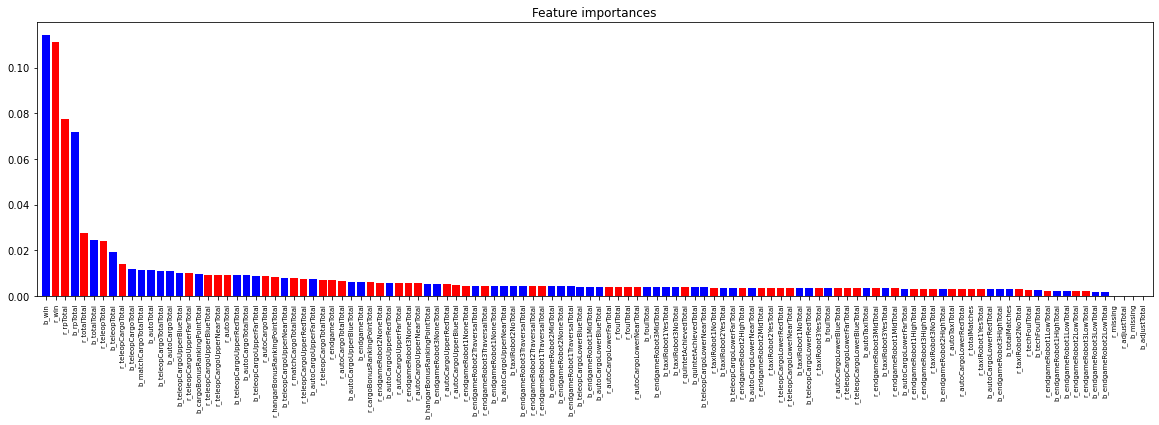

In [13]:
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = vectorizer.feature_names_

# Print the feature ranking
print("Feature ranking:")

#for f in range(trainX.shape[1]):
#    print("%d. %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))
colors = [names[indices[f]].split('_')[0] for f in range(trainX.shape[1])]
labels = [names[indices[f]].replace('Count','').replace('Points','').replace('red','r').replace('blue','b') for f in range(trainX.shape[1])]
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
plt.figure()
plt.title("Feature importances")
plt.bar(range(trainX.shape[1]), importances[indices],
       color=colors, 
        #yerr=std[indices], 
        align="center")
plt.xticks(range(trainX.shape[1]), labels, rotation='vertical', fontsize='x-small')
    
plt.xlim([-1, trainX.shape[1]])
plt.subplots_adjust(bottom=0.5)
#plt.legend()
plt.show()

In [15]:
def percentile(dictionary, key):
    teams = [t for t in dictionary]
    values = [dictionary[t][key] for t in dictionary]
    ranks = sorted(range(len(values)), key=lambda x: values[x])
    return dict([(teams[ranks[i]], i*100/len(values)) for i in range(len(ranks))])    

raw = dict([(k, percentile(teamAggregates,k)) for k in teamAggregates['frc1153']])
#stats = dict([(k,percentile(teamAggregates,k)['frc1153']) for k in teamAggregates['frc1153']])

The next cell enables comparisons between two teams.

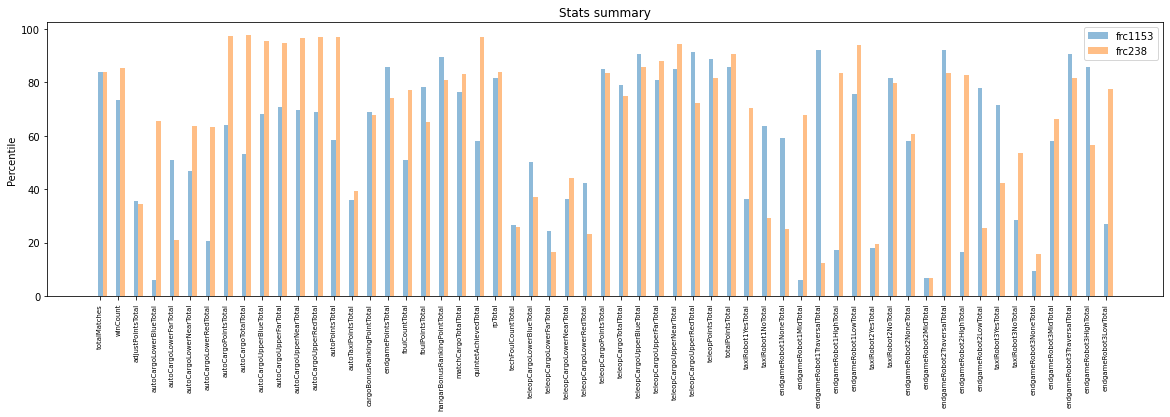

In [16]:
import matplotlib.pyplot as plt
import numpy as np

objects = [k for k in raw]
y_pos = np.arange(len(objects))
#performance = [[raw[k]['frc492'],raw[k]['frc2910']] for k in stats]
#performance
t1 = 'frc1153'
t2 = 'frc238'
plt.figure()
plt.bar(y_pos, [raw[k][t1] for k in raw], alpha=0.5, width=0.25)
plt.bar(y_pos+0.25, [raw[k][t2] for k in raw], alpha=0.5, width=0.25)
plt.xticks(y_pos, objects, rotation=90, fontsize='x-small')
plt.subplots_adjust(bottom=0.5)
plt.ylabel('Percentile')
plt.title('Stats summary')
plt.legend([t1,t2])

plt.show()


## Let's also try logistic regression.

In [17]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000)
classifier.fit(trainX,trainY)
lr_predictions= classifier.predict(testX)
accuracy_score(testY, lr_predictions)

0.775022143489814

Feature ranking:


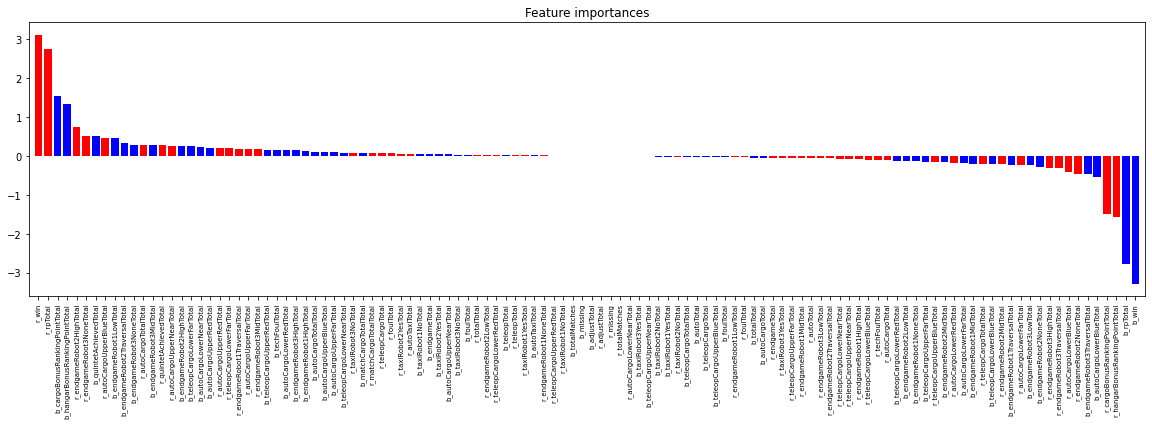

In [20]:
importances = classifier.coef_[0]
#std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
#             axis=0)
indices = np.argsort(importances)[::-1]
names = vectorizer.feature_names_

# Print the feature ranking
print("Feature ranking:")

#for f in range(trainX.shape[1]):
#    print("%d. %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))
colors = [names[indices[f]].split('_')[0] for f in range(trainX.shape[1])]
labels = [names[indices[f]].replace('Count','').replace('Points','').replace('red','r').replace('blue','b') for f in range(trainX.shape[1])]
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
plt.figure()
plt.title("Feature importances")
plt.bar(range(trainX.shape[1]), importances[indices],
       color=colors, 
        #yerr=std[indices], 
        align="center")
plt.xticks(range(trainX.shape[1]), labels, rotation='vertical', fontsize='x-small')
    
plt.xlim([-1, trainX.shape[1]])
plt.subplots_adjust(bottom=0.5)
#plt.legend()
plt.show()

## Linear Regression

In [21]:
from sklearn.linear_model import RidgeClassifier
classifier = RidgeClassifier()
classifier.fit(trainX,trainY)
predictions= classifier.predict(testX)
accuracy_score(testY, predictions)

0.7626217891939769

So far our best score at predicting the districts is 0.78 using either RandomForests.  Next time we can explore hyperparameter tuning and also predicting which alliances would have been the best ones for us to join.

Next steps: for a given event we want to decide how to prioritize alliance choices.  Suppose we have all the data to date, as well as all the qualifier data for the event. Who should we choose as partners?

In [73]:
# optimize alliances for frc492 at wasno:
import random
from tqdm import tqdm

event = '2022wasno'
teams = set([t for x in \
    [m.alliances.red.team_keys + m.alliances.blue.team_keys for m in matches['matches'][event]] \
        for t in x])

model_fn = 'model_2022_forest.pkl'
with open(model_fn, 'rb') as inF:
    vectorizer, model = pickle.load(inF)

target = 'frc492'
pairs = [(x,y) for x in teams if x!=target for y in teams if y!=target if x<y]
results = {}
features = []
alliances = []
for (x,y) in tqdm(pairs):
    red = [target, x, y]
    candidates = [x for x in teams if x not in red]
    trials = 100
    
    for m in range(trials):
        blue = random.sample(candidates, 3)
        f = featurizeAlliances(red, blue)
        features.append(f)
        alliances.append([red,blue])

scores = model.predict_proba(vectorizer.transform(features))
results = {}
for ((_,x,y),_), score in zip(alliances, scores): 
    if (x,y) not in results:
        results[(x,y)] = 0
    results[(x,y)] += score[0]    


for r in list(sorted(results, key=lambda x: results[x], reverse=True))[:100]:
    print(r, results[r])

 22%|██▏       | 109/496 [03:30<12:26,  1.93s/it]


KeyboardInterrupt: 